In [2]:
from GSM._imports import *
from torch.optim import Adam
from SSN._imports import *
from SSN.params import GridParameters
import torch
torch.autograd.set_detect_anomaly(True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# FoGSM

In [3]:
class FoGSMModel(nn.Module):
    def __init__(self,thetas=None, l_feature=1.0, l_amplitude=1.2, kappa=1.0, jitter=1e-5, grid_size=10, frequency=1.0,sigma=0.1):
        super(FoGSMModel, self).__init__()

        self.dtype = torch.float64

        self.l_feature = Parameter(torch.tensor(l_feature, dtype=self.dtype))
        self.l_amplitude = Parameter(torch.tensor(l_amplitude, dtype=self.dtype))
        self.kappa = Parameter(torch.tensor(kappa, dtype=self.dtype))
        self.frequency = Parameter(torch.tensor(frequency, dtype=self.dtype)) 
        self.sigma = Parameter(torch.tensor(sigma))

        if thetas is None:
            thetas = torch.linspace(0, 2 * np.pi, 8)  # 8 orientations from 0 to 2*pi
        self.thetas = thetas

        self.jitter = jitter
        self.grid_size = grid_size
        self.grid = torch.stack(torch.meshgrid(torch.linspace(-5, 5, grid_size), 
                                               torch.linspace(-5, 5, grid_size)), 
                                dim=-1).reshape(-1, 2)
        
        self.K_g = self.generate_K_g()
        
    def von_mises_kernel(self, theta1, theta2):
        theta_diff = theta1 - theta2  
        return torch.clamp(torch.exp(self.kappa * torch.cos(theta_diff)), min=1e-6)
    
    def squared_exponential_kernel(self, x1, x2, length_scale,jitter="True"):
        x1 = x1.unsqueeze(1) # Shape: [N, 1, 2]
        x2 = x2.unsqueeze(0) # Shape: [1, N, 2]
        sq_dist = torch.sum((x1 - x2) ** 2, dim=2) # Shape: [N, N]

        exp_term = torch.exp(-sq_dist / (2*length_scale**2))

        if jitter:
            return exp_term + self.jitter * torch.eye(x1.size(0))
        else:
            return exp_term

    def composite_feature_kernel(self, theta1, theta2):
         
        sq_exp_component = self.squared_exponential_kernel(self.grid, self.grid, self.l_feature,jitter="False")        
        
        # Ensure theta1 and theta2 are tensors
        theta1 = torch.tensor(theta1).clone().detach().requires_grad_(True)
        theta2 = torch.tensor(theta2).clone().detach().requires_grad_(True)

        x1 = self.grid.unsqueeze(1) # Shape: [N, 1, 2]
        x2 = self.grid.unsqueeze(0) # Shape: [1, N, 2]

        n1 = torch.tensor([torch.cos(theta1), torch.sin(theta1)]).view(1, 1, 2)  # Shape: [1, 1, 2]
        n2 = torch.tensor([torch.cos(theta2), torch.sin(theta2)]).view(1, 1, 2)  # Shape: [1, 1, 2]
        average_orientation = (n1 + n2) / 2

        # Broadcasting average_orientation for dot product computation
        average_orientation = average_orientation.repeat(x1.size(0), x1.size(1), 1)
        dot_product = torch.sum((x1 - x2) * average_orientation, dim=2)
        periodic_component = torch.cos(2 * torch.pi * self.frequency * dot_product)

        # Composite Kernel
        return sq_exp_component * periodic_component

    def generate_K_g(self):
        
        theta1_grid, theta2_grid = torch.meshgrid(self.thetas, self.thetas)
        ori_kernel_val = self.von_mises_kernel(theta1_grid, theta2_grid)
    
        # Spatial kernel
        loc_kernel_val = torch.zeros((len(self.thetas), len(self.thetas), self.grid_size**2, self.grid_size**2))

        for i in range(len(self.thetas)):
            for j in range(len(self.thetas)):
                loc_kernel_val[i,j] = self.composite_feature_kernel(self.thetas[i], self.thetas[j])
        
        K_spatial = torch.sum(loc_kernel_val, dim=[0, 1])
        K_g = torch.kron(K_spatial, ori_kernel_val)
        
        K_g = K_g + self.jitter * torch.eye(len(self.thetas)*self.grid_size**2)
        return K_g

    def compute_A(self):
        kernel_vals = self.squared_exponential_kernel(self.grid, self.grid, self.l_amplitude)
        return torch.sqrt(torch.exp(MultivariateNormal(torch.zeros(self.grid.size(0)), kernel_vals).sample()))

    def samples(self):

        g = MultivariateNormal(torch.zeros(len(self.thetas)*(self.grid_size**2)), self.K_g).sample()  
        A = self.compute_A()
        
        # Tile amplitudes to match feature fields 
        A = A.repeat(len(self.thetas))
    
        # Combine
        I = g * A  + torch.randn_like(g) * self.sigma
        #I = torch.sum(I.reshape(len(self.thetas), self.grid_size, self.grid_size), dim=0)

        return I, g
    
    def log_likelihood(self, I, g,A):
        A = A.repeat(len(self.thetas))
        I_hat = g * A
        #I_hat = torch.sum(I_hat.reshape(len(self.thetas), self.grid_size, self.grid_size), dim=0)
        print("Log likelihood I_hat ",I_hat.size())
        print("Log likelihood I ",I.size())
        return MultivariateNormal(I_hat.flatten(), self.sigma * torch.eye(self.grid_size**2)).log_prob(I.flatten())

    def likelihood(self, I, g,A):
        A = A.repeat(len(self.thetas))
        I_hat = g * A     

        # Ensure positive definite covariance matrix
        cov_matrix = self.sigma * torch.eye(I_hat.size(0))
        if not torch.isfinite(cov_matrix).all():
            print("Non-finite values in covariance matrix")
            return torch.tensor(float('nan'))
        
        return torch.exp(MultivariateNormal(I_hat, self.sigma * torch.eye(I_hat.size(0))).log_prob(I))

    def visualise(self, combined_fields):

        combined_fields = torch.sum(combined_fields.reshape(len(self.thetas), self.grid_size, self.grid_size), dim=0)

        # Normalise the combined image for visualisation
        combined_fields_normalised = combined_fields / combined_fields.max()

        # Reshape to image format
        combined_image = combined_fields_normalised.view(self.grid_size, self.grid_size).detach().numpy()

        # Visualise the combined image
        plt.figure(figsize=(5,5))
        plt.imshow(combined_image, cmap='gray') 
        plt.title('FoGSM Sample')
        plt.axis("off")
        plt.show()

    def generate_fogsm_dataset(self, num_samples, save=False,save_path=None):
        samples = []
        for _ in range(num_samples):
            I, g = self.samples()
            samples.append((I, g))
    
        # Convert samples to tensors
        images, gs = zip(*samples)
        images = torch.stack(images)
        gs = torch.stack(gs)
    
        if save:
            torch.save(images, gs, save_path)
        else:
            return images

    def visualise_samples(self, save_path, num_samples_to_visualise, grid_size):
        # Load the saved samples
        images, _ = torch.load(save_path)

        # Select a subset of samples to visualise
        selected_samples = images[:num_samples_to_visualise]

        # Create a grid of images
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)

        for i, ax in enumerate(axes.flat):
            if i < num_samples_to_visualise:
                image = selected_samples[i].detach().numpy()
                image = (image - image.min()) / (image.max() - image.min())

                ax.imshow(image, cmap='gray')
        
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

        plt.tight_layout()
        plt.show()

In [76]:
torch.manual_seed(0)

num_oris = 8
thetas = torch.linspace(0, torch.pi, num_oris)  # 8 orientations from 0 to pi
fogsm_params = {
        "thetas": thetas,
        "l_feature": 1.0,
        "l_amplitude": 1.5,
        "kappa": .5,
        "jitter": 1e-5,
        "grid_size": 3,
        "frequency": .2,
        "sigma": 0.1,
    }
fogsm_model = FoGSMModel(**fogsm_params)

# Generate and visualise a sample from the FoGSM model
I, g = fogsm_model.samples()
#fogsm_model.visualise(I)


/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_18419/3850355274.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta1 = torch.tensor(theta1).clone().detach().requires_grad_(True)
/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_18419/3850355274.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta2 = torch.tensor(theta2).clone().detach().requires_grad_(True)


# SSN

## SSN Base

In [114]:
class SSNBase(torch.nn.Module):
    def __init__(self, n, k, Ne, Ni, tau_e, tau_i, device='cpu', dtype=torch.float64):
        super().__init__()
        self.n = n
        self.k = k
        self.Ne = Ne
        self.Ni = Ni
        self.N = self.Ne + self.Ni
        self.device = device
        self.dtype = dtype
        self.register_buffer('EI', torch.cat([torch.ones(Ne), torch.zeros(Ni)]).to(device).bool())
        self.register_buffer('tau_vec', torch.cat([tau_e * torch.ones(Ne), tau_i * torch.ones(Ni)]).to(device, dtype))

        self.C_E = nn.Parameter(torch.tensor(2.4)) # taken from Echeveste et al. 2020
        self.C_I = nn.Parameter(torch.tensor(2.4)) # taken from Echeveste et al. 2020

        b = 13.24
        self.beta = nn.Parameter(torch.tensor(1.5 * b))
        self.gamma = nn.Parameter(torch.tensor(0.6)) # taken from Echeveste et al. 2020
    
    def drdt(self, r, inp_vec):
        return (-r + self.powlaw(self.W @ r + inp_vec)) / self.tau_vec

    def powlaw(self, u):
        return self.k * F.relu(u).pow(self.n)
    
    def dvdt_batch(self, v, inp_vec):
        # Ensure v and inp_vec are 2D tensors for batch processing
        if v.ndim == 1:
            v = v.unsqueeze(0)
        if inp_vec.ndim == 1:
            inp_vec = inp_vec.unsqueeze(0)

        #print(f"dvdt: v.shape={v.shape}, inp_vec.shape={inp_vec.shape}, W.shape={self.W.shape}")

        # Compute W @ r for batch processing
        W_r = self.W @ self.powlaw(v).T
        W_r = W_r.T  # Transpose back to match batch dimension

        return (-v + W_r + inp_vec) / self.tau_vec
    
    def process_input(self, input_batch):

        # Non-linearity for the input to the network
        input_rectified = F.relu(self.beta + input_batch)
        epsilon = 1e-6  # Small value to avoid zero
        input_processed = (input_rectified + epsilon) ** self.gamma

        # Multiply the input batch by C_E and C_I scalars
        input_weighted = torch.cat([
            self.C_E * input_processed,
            self.C_I * input_processed
        ], dim=-1)

        return input_weighted

    def simulate_batch_rates(self, inp_vec, v_init=None, duration=500, dt=1,noise=None):
        # inp_vec: [batch_size, num_neurons]
        # v_init: [batch_size, num_neurons]
        # returns: [batch_size, time_steps, num_neurons]
        
        time_steps = int(duration/dt)
        print(f"simulate: time_steps={time_steps}, dt={dt}, duration={duration}")
        # Check if inp_vec is a batch of inputs
        if inp_vec.ndim == 2:
            batch_size, self.N = inp_vec.shape 
            inp_vec = inp_vec.unsqueeze(1).expand(-1, time_steps, -1)
        else:
            raise ValueError("inp_vec must be a 2D tensor of shape [batch_size, num_neurons].")

        #print(f"simulate: batch_size={batch_size}, time_steps={time_steps}, inp_vec.shape={inp_vec.shape}")

        # Initialise v_init if not provided
        if v_init is None:
            v_init = torch.zeros((batch_size, self.N), device=self.device, dtype=self.dtype)
        else:
            if isinstance(v_init, (int, float)):
                v_init = torch.full((batch_size, self.N), v_init, device=self.device, dtype=self.dtype)
            if v_init.shape[0] != batch_size or v_init.shape[1] != self.N:
                raise ValueError("v_init shape does not match batch_size or neuron count N.")
        
        # Initialise noise if not provided
        if noise is None:
            noise = torch.zeros((time_steps, self.N), device=self.device, dtype=self.dtype)
        else:
            if noise.shape[0] != time_steps or noise.shape[1] != self.N:
                raise ValueError("noise shape does not match time_steps or neuron count N.")

        # rates: [batch_size, time_steps, Ne]
        rates_E = torch.zeros((batch_size, time_steps, self.Ne), device=self.device, dtype=self.dtype)
        v = v_init
        t = dt
        while t < duration:
            # Calculate dv for each element in the batch at the current time step
            dv = self.dvdt_batch(v, inp_vec[:, t, :]+noise[t])  # dv: [batch_size, num_neurons]

            # Update the membrane potentials for the current time step
            v += dt * dv

            # take an average of membrane potentials over trials at each time step is constant over time
            # but trials doesny ecist so instead average over neurons but not image

            # TODO: throw away the first 100 ms burn-in time of the simulation to allow the network to settle to a stable state before recording the firing rates

            # Compute the firing rates from the updated membrane potentials
            r = self.powlaw(v) # r: [batch_size, num_neurons]

            # Store the rates for the current time step
            if t % 5 == 0:
                rates_E[:, t, :] = r[:, :self.Ne] # rates: [batch_size, time_steps, Ne]

            t = t + dt

        return rates_E
    
    def simulate_batch(self, inp_vec, v_init=None, duration=500, dt=1,burn_in_time=100,noise=None):
        # inp_vec: [batch_size, num_neurons]
        # v_init: [batch_size, num_neurons]
        # returns: [batch_size, time_steps, num_neurons]
        
        time_steps = int(duration/dt)

        print(f"simulate: time_steps={time_steps}, dt={dt}, duration={duration}")

        if inp_vec.ndim == 2:
            batch_size, self.N = inp_vec.shape 
            inp_vec = inp_vec.unsqueeze(1).expand(-1, time_steps, -1)
        else:
            raise ValueError("inp_vec must be a 2D tensor of shape [batch_size, num_neurons].")
        
        # Initialise v_init if not provided
        if v_init is None:
            v_init = torch.zeros((batch_size, self.N), device=self.device, dtype=self.dtype)
        else:
            if isinstance(v_init, (int, float)):
                v_init = torch.full((batch_size, self.N), v_init, device=self.device, dtype=self.dtype)
            if v_init.shape[0] != batch_size or v_init.shape[1] != self.N:
                raise ValueError("v_init shape does not match batch_size or neuron count N.")
        
        # Initialise noise if not provided
        if noise is None:
            noise = torch.zeros((time_steps, self.N), device=self.device, dtype=self.dtype)
        else:
            if noise.shape[0] != time_steps or noise.shape[1] != self.N:
                raise ValueError("noise shape does not match time_steps or neuron count N.")

        # rates: [batch_size, time_steps, Ne]
        potentials_E = torch.zeros((batch_size, time_steps, self.Ne), device=self.device, dtype=self.dtype)
        v = v_init
        t = 0

        while t < duration:
            # Calculate dv for each element in the batch at the current time step
            dv = self.dvdt_batch(v, inp_vec[:, t, :]+noise[t])  # dv: [batch_size, num_neurons]

            # Update the membrane potentials for the current time step
            v += dt * dv # v: [batch_size, num_neurons]

            # Store every 5th time step
            if t >= burn_in_time:
                # Store every 5th time step after the burn-in period
                if (t - burn_in_time) % 5 == 0:
                    potentials_E[:, t, :] = v[:, :self.Ne] # rates: [batch_size, time_steps, Ne]

            t = t + dt

        return potentials_E

## SSN 2DTopo

In [115]:
class SSN2DTopo(SSNBase):
    def __init__(self, n, k, tauE, tauI, grid_pars, conn_pars, thetas, L = np.pi,device='cpu', dtype=torch.float64):
         
        num_oris = thetas.shape[0]
        grid_size = grid_pars['grid_size_Nx']
                
        Ne = num_oris * (grid_size ** 2)
        Ni = num_oris * (grid_size ** 2)

        super(SSN2DTopo, self).__init__(n=n, k=k, Ne=Ne, Ni=Ni, tau_e=tauE, tau_i=tauI, device=device, dtype=dtype)
        
        self.num_oris = num_oris
        self.grid_size = grid_size
        self.Ne = Ne
        self.Ni = Ni
        self.L = L
        self.thetas = thetas
        self._make_maps()
        
        # Initialise trainable parameters
        if conn_pars is None:
            conn_pars = {
                'J_2x2': torch.rand(2, 2, device=device, dtype=dtype),  
                's_2x2': torch.rand(2, 2, device=device, dtype=dtype),  
                'p_local': torch.rand(2, device=device, dtype=dtype),  
                'sigma_oris': torch.rand(1, device=device, dtype=dtype)  
            }
            
        self.J_2x2 = nn.Parameter(conn_pars['J_2x2'])  # Interaction strengths
        self.s_2x2 = nn.Parameter(conn_pars['s_2x2']) # Spatial length scales
        self.p_local = nn.Parameter(conn_pars['p_local']) # Local connectivity strengths
        self.sigma_oris = nn.Parameter(conn_pars['sigma_oris']) # Orientation tuning width
        
        self.make_W()

    def _make_maps(self):

        self.ori_map = torch.tensor(self.thetas, device=self.device, dtype=self.dtype).flatten()
        self.ori_vec = self.ori_map.repeat(self.grid_size ** 2)  # Repeat orientation values for each grid cell
        self.ori_vec = self.ori_vec.repeat(2) # Repeat for E and I populations

        # Create x and y vectors for grid cells
        self.x_vec = torch.arange(self.grid_size, device=self.device, dtype=self.dtype).repeat_interleave(self.num_oris).repeat(self.grid_size)
        self.y_vec = torch.arange(self.grid_size, device=self.device, dtype=self.dtype).repeat_interleave(self.num_oris * self.grid_size)

        # Repeat for E and I populations
        self.x_vec = self.x_vec.repeat(2)
        self.y_vec = self.y_vec.repeat(2)
    
    def calc_xy_dist(self):
        Ne = Ni = self.Ne
        x_vec_e = self.x_vec[:Ne]
        y_vec_e = self.y_vec[:Ne]
        x_vec_i = self.x_vec[Ne:Ne+Ni]
        y_vec_i = self.y_vec[Ne:Ne+Ni]
        
        xy_dist = torch.cdist(torch.stack([x_vec_e, y_vec_e], dim=1), torch.stack([x_vec_i, y_vec_i], dim=1), p=2).repeat(2, 2) 

        return xy_dist
    
    def calc_ori_dist(self,L=np.pi, method=None):

        Ne = self.num_oris * self.grid_size ** 2
        ori_vec = self.ori_vec[:Ne]

        if method == "absolute":
            ori_dist = torch.cdist(ori_vec.unsqueeze(1), ori_vec.unsqueeze(1)).repeat(2,2)
        else:
            #1 - cos(2(pi/L) * |theta1 - theta2|^2)
            ori_diff = torch.abs(ori_vec.unsqueeze(1) - ori_vec.unsqueeze(0))
            ori_diff = torch.min(ori_diff, 2*np.pi - ori_diff)
            sq_ori_dist = 1 - torch.cos((2*np.pi / L) * ori_diff**2)
                    
        sq_ori_dist = sq_ori_dist.repeat(2, 2)

        return sq_ori_dist

    def make_W(self):
        
        xy_dist = self.calc_xy_dist()
        sq_ori_dist = self.calc_ori_dist()

        # Compute weight blocks
        W_ee = self.calc_W_block(xy_dist[:self.Ne, :self.Ne], sq_ori_dist[:self.Ne, :self.Ne], self.s_2x2[0][0], self.sigma_oris, excitatory='EE')
        W_ei = self.calc_W_block(xy_dist[:self.Ne, self.Ne:], sq_ori_dist[:self.Ne, self.Ne:], self.s_2x2[0][1], self.sigma_oris, excitatory='EI')
        W_ie = self.calc_W_block(xy_dist[self.Ne:, :self.Ne], sq_ori_dist[self.Ne:, :self.Ne], self.s_2x2[1][0], self.sigma_oris)
        W_ii = self.calc_W_block(xy_dist[self.Ne:, self.Ne:], sq_ori_dist[self.Ne:, self.Ne:], self.s_2x2[1][1], self.sigma_oris)
        
        # Apply local connectivity strengths
        W_ee = self.p_local[0] * torch.eye(self.Ne, device=self.device, dtype=self.dtype) + (1 - self.p_local[0]) * W_ee
        W_ei = self.p_local[1] * torch.eye(self.Ni, device=self.device, dtype=self.dtype) + (1 - self.p_local[1]) * W_ei
                
        # Concatenate submatrices to form W
        W = torch.cat([
            torch.cat([self.J_2x2[0, 0] * W_ee, self.J_2x2[0, 1] * W_ei], dim=1).clone().detach(),
            torch.cat([self.J_2x2[1, 0] * W_ie, self.J_2x2[1, 1] * W_ii], dim=1).clone().detach()
        ], dim=0).double()

        # Register W as a buffer
        self.register_buffer('W', W)
        
        return self.W

    def calc_W_block(self, xy_dist, sq_ori_dist, s, sigma_oris, CellWiseNormalised = True, excitatory=None):

        #Add a small constant to s and sigma_oris to avoid division by zero
        s = s + 1e-8
        sigma_oris = 2*np.pi*sigma_oris/self.L + 1e-8
        
        if excitatory == 'EE':
            W =  torch.exp(-xy_dist / s - sq_ori_dist / (2 * sigma_oris ** 2))
        else:
            W =  torch.exp(-xy_dist ** 2 / (2 * s ** 2) - sq_ori_dist / (2 * sigma_oris ** 2))
                               
        W = torch.where(W < 1e-4, torch.zeros_like(W), W)

        sW = torch.sum(W, dim=1, keepdim=True)
        if CellWiseNormalised:
            W = torch.div(W, sW)
        else:
            sW = sW.mean()
            W = W / sW

        return W.squeeze()
    
    def make_correlated_noise(self, dt, Nt, corr_time, grid_size=3):

        # Generate temporally correlated noise
        Tfilt = 10 * corr_time
        Nfilt = int(Tfilt / dt)
        ttfilt = torch.arange(0, Nfilt+1,dtype=torch.float32) * dt
        assert Nt > len(ttfilt)
        filter = torch.exp(-ttfilt / corr_time) * dt / corr_time

        white_noise = torch.randn(self.N, Nt + Nfilt) / torch.sqrt(torch.tensor(dt)) * torch.sqrt(torch.tensor(2 * corr_time))

        noise = []
        for nn in range(self.N):
            coloured = torch.conv1d(white_noise[nn:nn+1, :].unsqueeze(0), filter.unsqueeze(0).unsqueeze(0), padding='valid').squeeze()
            noise.append(coloured)
        noise = torch.stack(noise)

        # params taken from Echeveste et al. 2020 - optimised values
        noise_var_EI=torch.tensor([6.399186720550809504,3.533514014946008697]) 
        noise_std_EI = torch.sqrt(noise_var_EI)
        rho = 0.992852418877574472 
        d_sigma = 0.477952645032425183

        # Introduce spatial correlations
        sigma_e = noise_std_EI[0]
        sigma_i = noise_std_EI[1]
        
        theta_unsq = self.thetas.unsqueeze(1)  
        theta_unsq_T = self.thetas.unsqueeze(0)  

        sigma_ee = sigma_e**2 * torch.exp((torch.cos(2 * (theta_unsq - theta_unsq_T)) - 1) / d_sigma**2)
        sigma_ii = sigma_i**2 * torch.exp((torch.cos(2 * (theta_unsq - theta_unsq_T)) - 1) / d_sigma**2)
        sigma_ei = rho * sigma_e * sigma_i * torch.exp((torch.cos(2 * (theta_unsq - theta_unsq_T)) - 1) / d_sigma**2)
        sigma_ie = rho * sigma_e * sigma_i * torch.exp((torch.cos(2 * (theta_unsq_T - theta_unsq)) - 1) / d_sigma**2)

        blocks = [
            torch.kron(torch.eye(grid_size**2), sigma_ee),
            torch.kron(torch.eye(grid_size**2), sigma_ei),
            torch.kron(torch.eye(grid_size**2), sigma_ie),
            torch.kron(torch.eye(grid_size**2), sigma_ii)
        ]

        sigma = torch.cat([
            torch.cat([blocks[0], blocks[1]], dim=1),
            torch.cat([blocks[2], blocks[3]], dim=1)
        ], dim=0).double()

        sigma = sigma + 1e-6 * torch.eye(sigma.size(0))
        cholesky = torch.linalg.cholesky(sigma)

        # set dtype to float64
        noise = noise.double()
        cholesky = cholesky.double()

        correlated_noise = cholesky @ noise

        return correlated_noise.T

## SSN Main

In [116]:
n = 2
k = 0.3
tauE = 20.0
tauI = 10.0
grid_pars = {'grid_size_Nx': 3}

psi = torch.tensor(0.774)
conn_pars = {
    'J_2x2': torch.tensor([[.624, -1.931], [1.049, -0.537]],dtype=torch.float64) *torch.pi * psi, #TODO: take their a and multiply by 2 * num thetas in echeveste
    's_2x2': torch.tensor([[0.2955, 0.09], [0.5542, 0.09]])/0.4,  # TODO: divide by 0.4
    'p_local': torch.tensor([0.72,0.7]),  
    'sigma_oris': torch.tensor(45.0),
    'num_oris': 8}

thetas = torch.linspace(0, torch.pi, conn_pars['num_oris'])

ssn_params = {
        "n": 2,
        "k": k,
        "tauE": 20,
        "tauI": 10,
        "grid_pars": grid_pars,
        "conn_pars": conn_pars,
        "thetas": thetas,
    }

In [117]:
# produce a fogsm sample
I, g = fogsm_model.samples()

# simulate the SSN model
ssn_model = SSN2DTopo(**ssn_params)

# process the input
inp_vec = ssn_model.process_input(I)
inp_vec = inp_vec.unsqueeze(0)

# create correlated noise
dt = 1
Nt = 500
corr_time = 10
noise = ssn_model.make_correlated_noise(dt, Nt, corr_time)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_18419/1401682589.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ori_map = torch.tensor(self.thetas, device=self.device, dtype=self.dtype).flatten()


simulate: time_steps=500, dt=1, duration=500


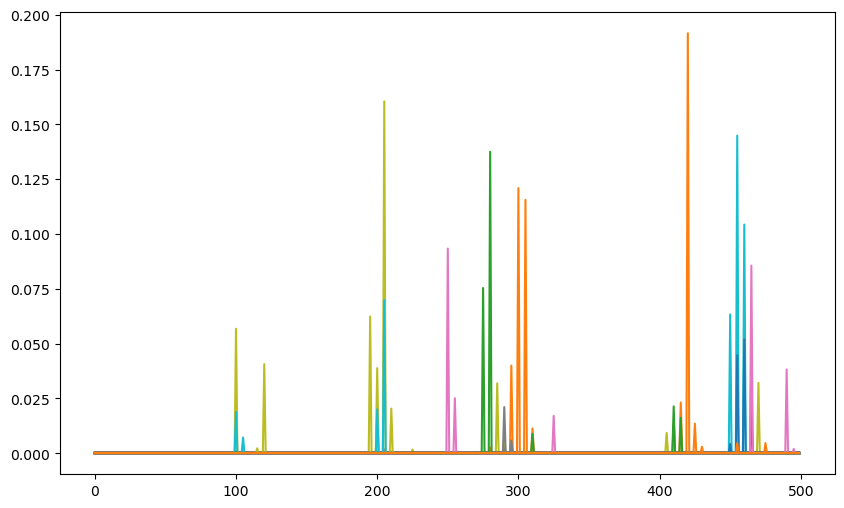

In [120]:
# simulate the SSN model
potentials = ssn_model.simulate_batch(inp_vec, duration=500, dt=1,noise=noise)
rates = ssn_model.powlaw(potentials)

# plot the rate of ith neuron over time
for i in range (ssn_model.Ne):
    if rates[0,:,i].max() < 10000:
        plt.plot(rates[0,:,i].detach().numpy())
    else:
        print("Rate of neuron ",i," is too high to plot")
plt.show()

# ELBO

In [134]:
class DirectFit:
    def __init__(self, ssn_params, fogsm_params):
        
        super(DirectFit, self).__init__()
        self.ssn_model = SSN2DTopo(**ssn_params)
        self.fogsm_model = FoGSMModel(**fogsm_params)

    def sample_trajectories(self, input_batch, duration=500, dt=.2):

        input_weighted = self.ssn_model.process_input(input_batch)

        # Ensure input_reshaped has correct dimensions before calling simulate
        if input_weighted.shape[1] != self.ssn_model.N:
            input_weighted = input_weighted.view(input_weighted.shape[0], self.ssn_model.N)
        
        # Geenrate noise
        noise = self.ssn_model.make_correlated_noise(dt=dt, Nt=int(duration/dt),corr_time=0.5,grid_size=3)
            
        # Generate trajectories for the reshaped input
        potentials = self.ssn_model.simulate_batch(input_weighted, duration=duration, dt=dt,noise=noise)
        trajectories = self.ssn_model.powlaw(potentials)

        return trajectories,potentials

    def calculate_log_p_g(self, trajectory):
        # trajectory: [num_samples_g, dim]
        # expectation over g in Eq (25) (1st term), i.e., (sub-sampled) time-steps of SSN simulation, corresponding to samples from variational posterior of g

        num_neurons = trajectory.shape[1]  # Number of neurons
        dim = trajectory.shape[0]            # Number of time points

        # Mean vector for the multivariate normal (zero mean)
        mean = torch.zeros(num_neurons, device=trajectory.device, dtype=trajectory.dtype)
    
        # Covariance matrix for the multivariate normal
        cov = self.fogsm_model.K_g

        # Check covariance matrix shape
        assert cov.shape == (num_neurons, num_neurons), f"Expected covariance matrix of shape ({num_neurons}, {num_neurons}), but got {cov.shape}"

        # Multivariate normal distribution
        mvg = MultivariateNormal(mean, cov)

        # Calculate log probabilities for all samples in the trajectory
        log_probs = []
        for g in trajectory:
            if torch.isnan(g).any() or torch.isinf(g).any():
                print("Invalid values in g:", g)
            log_probs.append(mvg.log_prob(g))  # log_probs: [num_samples_g]

        log_probs = torch.tensor(log_probs, device=trajectory.device, dtype=trajectory.dtype)
        if torch.isnan(log_probs).any():
            print("NaN detected in log_probs")

        # Return the mean log probability
        log_p_g = log_probs.mean()

        return log_p_g


    def calculate_log_p_I_given_g(self, I_data, trajectory, A_samples, epsilon=1e-6):

        log_likelihood = 0

        # expectation over g in Eq (25) (2nd term)
        for g in trajectory: # runs over (sub-sampled) time-steps of SSN simulation, corresponding to samples from variational posterior of g
            p_I_g = 0

            # expectation over A in Eq (25)
            for a in A_samples: # for computational cost reasons, currently using the same samples for A for all images in a batch (but we resample across mini-batches) 
                p_I_g = p_I_g + self.fogsm_model.likelihood(I_data, g, a) # I_data is a single image from the dataset and g is a single sample
                                                                          # for g from the SSN
                #check if p_I_g is zero or negative
                if p_I_g < 0:
                    print("p_I_g is zero")

            avg_p_I_g = p_I_g / len(A_samples)
            avg_p_I_g = torch.clamp(avg_p_I_g, min=epsilon) # to avoid log(0)

            log_likelihood = log_likelihood + torch.log(avg_p_I_g)
        
        return log_likelihood / len(trajectory)

    def calc_lambda_0(self,elbo_batches,potentials):
        # potentials: [batch_size, time_steps, num_neurons]
        # elbo: [batch_size]

        # Calculate the mean of squared potentials
        v_squared = potentials**2
        avg_v_squared = torch.mean(v_squared, dim=-1) # Average over neurons - [batch_size, time_steps]

        print("Avg v squared: ", avg_v_squared.shape)
        print("ELBO batches: ", elbo_batches.shape)
        lambda_0 = elbo_batches.unsqueeze(1) / avg_v_squared # [batch_size, time_steps]

        return lambda_0
    
    def regularisation_term(self, potentials, elbo_image, skip_steps=10, lambda_factor=1.0, option='b'):
        # potentials: [batch_size, time_steps, num_neurons]

        # Calculate the average of squared potentials over neurons
        v_mean = torch.mean(potentials**2, dim=-1) # shape: [batch_size, time_steps]

        # Calculate the regularization term
        time_steps = v_mean.shape[0]

        indices = torch.arange(0, time_steps, skip_steps)
        v_mean = v_mean[indices]

        if option == 'a':
            # Option a) Taking the absolute difference of nearest neighbor time steps
            diff_a = torch.abs(v_mean[1:] - v_mean[:-1])
            reg_term = torch.sum(diff_a)
        else:
            # Option b) Taking the difference across all pairs of time steps
            diff_b = torch.abs(v_mean.unsqueeze(0) - v_mean.unsqueeze(1)) 
            reg_term = torch.sum(diff_b) 
        
        lambda_0 = self.calc_lambda_0(elbo_image,potentials)
        
        # reg_term shape: [batch_size]
        # lambda_0 shape: [batch_size, time_steps]
        
        print("Reg term: ", reg_term.shape)
        print("Lambda_0: ", lambda_0.shape)
        
        reg_term = lambda_factor * lambda_0 * reg_term

        return reg_term

    def calculate_elbo(self, input_batch, A_samples, duration=500, dt=.2):

        # Sample trajectories from the SSN
        trajectories,potentials = self.sample_trajectories(input_batch=input_batch, duration=duration, dt=dt)

        elbo = 0
        for I, trajectory in zip(input_batch, trajectories): # trajectory is the trajectory for a single image
            log_p_g = self.calculate_log_p_g(trajectory)
            log_p_I_given_g = self.calculate_log_p_I_given_g(I, trajectory, A_samples)

            cov_matrix = torch.cov(trajectory.T)

            if not torch.isfinite(cov_matrix).all():
                print("Non-finite values in covariance matrix")
            
            if torch.isnan(cov_matrix).any():
                print("NaN detected in cov_matrix")
            
            cov_matrix = cov_matrix + 1e-6 * torch.eye(cov_matrix.size(0))
            entropy_term = 0.5 * torch.logdet(cov_matrix)

            print("ELBO terms: ", log_p_g, log_p_I_given_g, entropy_term)
 
            elbo_image = log_p_g + log_p_I_given_g + entropy_term 

            # TODO: add a penalty term for nearest neighbour correlation in g 
            elbo = elbo + elbo_image + self.regularisation_term(potentials,elbo_image)

        return elbo / len(input_batch)
        
    def optimise_elbo(self, batch_size, num_samples_a, threshold=1e-3, optimizer_cls=Adam, lr=1e-3,duration=10, dt=0.2):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.ssn_model.to(device)
        self.fogsm_model.to(device)

        optimizer = optimizer_cls(list(self.ssn_model.parameters()), lr=lr)
        batch = 0
        prev_elbo = float('-inf')
        elbo_values = []  

        while True:
            
            optimizer.zero_grad()  # Zero gradients at the beginning of each batch

            elbo_batch = 0

            # Sample amplitude fields from the prior p(A) using Monte Carlo sampling
            A_samples = [self.fogsm_model.compute_A() for _ in range(num_samples_a)]

            # Generate a mini-batch of input data
            input_batch = self.fogsm_model.generate_fogsm_dataset(batch_size).to(device)

            # Calculate the ELBO for the mini-batch
            elbo_batch = self.calculate_elbo(input_batch, A_samples, duration=duration, dt=dt)

            if torch.isnan(elbo_batch).any():
                print("NaN detected in elbo_batch")
                break

            # Optimise the ELBO with respect to the model parameters
            elbo_batch.backward(retain_graph=True)
            optimizer.step()

            # Print the ELBO for monitoring
            if (batch + 1) % 1 == 0:
                print(f"Batch [{batch+1}], ELBO: {elbo_batch / batch_size:.4f}")

            # Check for convergence
            if abs(elbo_batch - prev_elbo) < threshold:
                print(f"Converged after {batch+1} batches.")
                break

            prev_elbo = elbo_batch
            batch = batch + 1
            elbo_values.append(elbo_batch.item())

            if batch > 100:
                # plot the elbo values
                plt.plot(elbo_values)
                plt.xlabel("Batch")
                plt.ylabel("ELBO")
                plt.title("ELBO values")
                plt.show()

                break
        
        return self.ssn_model, self.fogsm_model

In [135]:
direct_fit = DirectFit(ssn_params, fogsm_params)
direct_fit.optimise_elbo(batch_size=3, num_samples_a=10, optimizer_cls=Adam, lr=0.001, duration=100, dt=1) #TODO: grab samples every 5ms

/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_18419/1401682589.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ori_map = torch.tensor(self.thetas, device=self.device, dtype=self.dtype).flatten()
/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_18419/3850355274.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta1 = torch.tensor(theta1).clone().detach().requires_grad_(True)
/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_18419/3850355274.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# Compute the standard deviation of FoGSM images

fogsm_model = FoGSMModel(**fogsm_params)
num_samples = 10000
samples = []
for _ in range(num_samples):
    I, g = fogsm_model.samples()
    samples.append((I, g))
images, _ = zip(*samples)
images = torch.stack(images)
sd = images.std()
print("Standard deviation of images: ", sd)

/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_83470/3445253102.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta1 = torch.tensor(theta1).clone().detach().requires_grad_(True)
/var/folders/l7/fy1r11ts4_3988dhm6lgmr2w0000gn/T/ipykernel_83470/3445253102.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta2 = torch.tensor(theta2).clone().detach().requires_grad_(True)


Standard deviation of images:  tensor(13.2183, grad_fn=<StdBackward0>)
